In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Import preproc data

In [2]:
path = 'data/preprocessed'
file_name = 'preproc'
df = pd.read_csv(f'../{path}/{file_name}.csv')
df.head(3)

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown,year,month,day_of_week,utc_offset
0,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0
1,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0
2,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0


## Keep only data where vessels are not fishing

In [3]:
df = df.dropna()

In [4]:
zero = df[df['is_fishing']==0]
zero.shape

(300765, 20)

### Small sample size

In [5]:
sample_size = 50000
start_index = 0
# Create a smaller sequential subset
data = zero.iloc[start_index:start_index+sample_size]
data.shape

(50000, 20)

In [53]:
# Defining X - features
X = data.drop(['date', 'year', 'is_fishing','utc_offset'], axis=1)
X.head(3)

,mmsi,distance_from_shore,distance_from_port,speed,course,lat,lon,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown,month,day_of_week
0,1.252340e+12,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,3
1,1.252340e+12,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,3
2,1.252340e+12,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,3


# OneClassSVM 

## Pipeline

In [151]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import OneClassSVM
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline


# Splitting features into continuous and categorical
continuous_features = ['distance_from_shore', 'distance_from_port', 'speed', 'course', 'lat', 'lon']
categorical_features = ['day_of_week']

# Creating pipelines for preprocessing
continuous_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, continuous_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Creating the One-Class SVM model pipeline
svm = make_pipeline(
    preprocessor,
    OneClassSVM(kernel='rbf', nu=0.01, gamma=0.01)  # You can adjust nu and gamma
)
svm

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cont', StandardScaler(),
                                                  ['distance_from_shore',
                                                   'distance_from_port',
                                                   'speed', 'course', 'lat',
                                                   'lon']),
                                                 ('cat', OneHotEncoder(),
                                                  ['day_of_week'])])),
                ('oneclasssvm', OneClassSVM(gamma=0.01, nu=0.01))])

In [152]:
# Fitting the model
svm.fit(data)

# Predictions
pred = svm.predict(data)

In [153]:
np.unique(pred)

array([-1,  1])

# Map data where anomaly was detected by model

In [154]:
from numpy import quantile, where, random
anom_index = where(pred == -1)
anom_index[0].shape

(2034,)

In [155]:
anom_df = X.iloc[anom_index[0]]
print('number of datapoint: ',X.shape[0])
print('number of anomalies in data: ',anom_df.shape[0])
print('Proportion= ', (100*anom_df.shape[0]/X.shape[0]))

number of datapoint:  50000
number of anomalies in data:  2034
Proportion=  4.068


## Visualise single vessel

### single vessel anomalies

In [163]:
single_vessel_mmsi = anom_df['mmsi'].iloc[800]
single_vessel_anom_df = anom_df.loc[anom_df['mmsi'] == single_vessel_mmsi]
single_vessel_anom_lat_lon = single_vessel_anom_df[['lat', 'lon']]
single_vessel_anom_lat_lon.shape

(773, 2)

### single vessel datapoint

In [164]:
single_vessel_df = X.loc[X['mmsi']== single_vessel_mmsi]
single_vessel_lat_lon = single_vessel_df[['lat', 'lon']]
single_vessel_lat_lon.shape

(10462, 2)

## Plot single vessel datapoint and associated anomalies

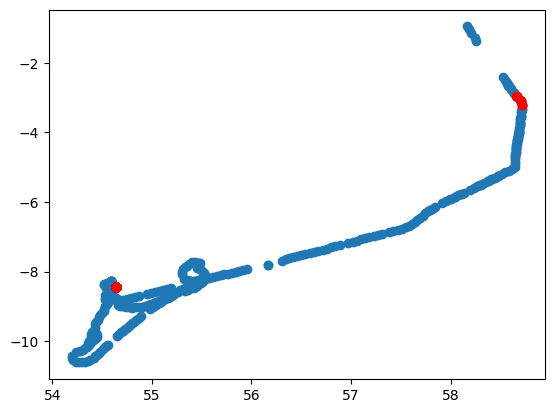

In [165]:
plt.scatter(single_vessel_lat_lon['lat'],single_vessel_lat_lon['lon'])
# plt.show()
plt.scatter(single_vessel_anom_lat_lon['lat'], single_vessel_anom_lat_lon['lon'], color='r')
plt.show()

# Plot on world map

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [49]:
geometry = [Point(xy) for xy in zip(single_vessel_lat_lon['lon'], single_vessel_lat_lon['lat'])]

In [50]:
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(single_vessel_lat_lon, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_df.head()

/home/pgducray/.pyenv/versions/3.10.6/envs/fishing_classification/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,lat,lon,geometry
6249,53.749012,8.505705,POINT (8.50570 53.74901)
6250,53.941181,8.233684,POINT (8.23368 53.94118)
6291,53.738258,8.516247,POINT (8.51625 53.73826)
6292,53.738270,8.516225,POINT (8.51622 53.73827)
6336,53.738247,8.516245,POINT (8.51624 53.73825)


/tmp/ipykernel_1706/240868973.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
/tmp/ipykernel_1706/240868973.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, cmap='autumn')


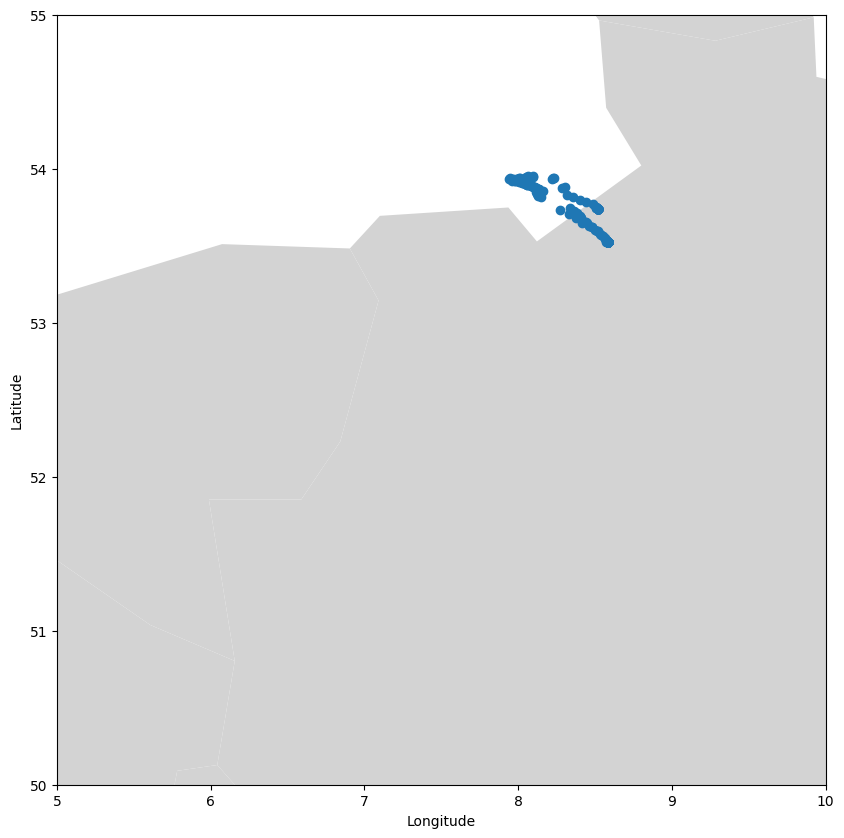

In [52]:
# Getting world map data from geo pandas
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(16, 10))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting Longitudes and Latitudes of one boat
x = single_vessel_lat_lon['lon']
y = single_vessel_lat_lon['lat']
plt.scatter(x, y, cmap='autumn')

# Creating axis limits and title
plt.xlim([5, 10])
plt.ylim([50, 55])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()